# Experiments with Multi Scale Entropy for Unsupervised Classification

Reference: https://arxiv.org/abs/2206.13529

## Imports

In [50]:
import pickle
import george
import scipy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyentrp import entropy as ent
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
%matplotlib inline

## Load ELAsTiCC data set

In [4]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [5]:
test_dir = "/Users/vedshah/Documents/Research/UIUCSN/Projects/ELAsTiCC-Classification/processed/train"
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

In [213]:
idx = 65132
astrophysical_classes[idx]

'AGN'

In [214]:
df = X_ts[idx]
df

,scaled_time_since_first_obs,detection_flag,scaled_FLUXCAL,scaled_FLUXCALERR,band_label
0,0.000000,0,-0.002241,0.003193,0.6215
1,0.000117,0,0.006171,0.004586,0.7545
2,0.069195,0,-0.013324,0.027217,1.0150
3,0.069217,0,0.007544,0.026654,1.0150
4,0.069426,0,0.003340,0.024538,1.0150
...,...,...,...,...,...
173,8.468610,0,0.005808,0.005428,0.3600
174,8.468839,0,-0.006544,0.003306,0.4760
175,8.486959,0,0.006123,0.005050,0.3600
176,8.488174,0,-0.013916,0.003754,0.6215


(178, 2)


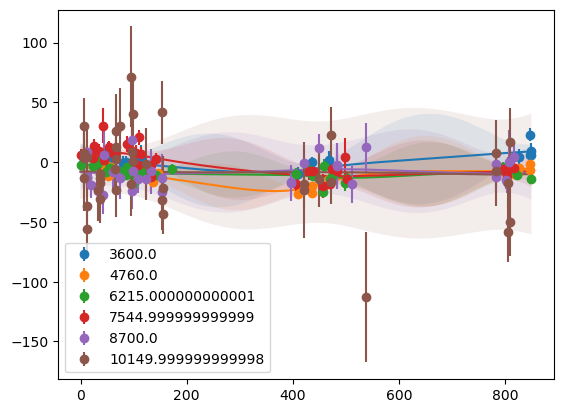

In [215]:
# Drop the non detections
#df = df[df['detection_flag'] == 1]

mjd = df['scaled_time_since_first_obs'].to_numpy() * 100
band = df['band_label'].to_numpy() * 10000
flux = df['scaled_FLUXCAL'].to_numpy() * 1000
flux_err = df['scaled_FLUXCALERR'].to_numpy() * 1000

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(flux)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(flux)

times = np.linspace(0, max(mjd), 1000)

signal_to_noises = np.abs(flux) / np.sqrt(
    flux_err ** 2 + (1e-2 * np.max(flux)) ** 2
)
scale = np.abs(flux[signal_to_noises.argmax()])

kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel(
    [200 ** 2, 6000 ** 2], ndim=2
)


gp = george.GP(kernel)

print(np.array([mjd, band]).T.shape)
gp.compute(np.array([mjd, band]).T, flux_err)

result = scipy.optimize.minimize(neg_ln_like,
                                 gp.get_parameter_vector(),
                                 jac=grad_neg_ln_like)
gp.set_parameter_vector(result.x)

filters = np.unique(band)

for i, filter_ in enumerate(filters):
    pred, pred_var = gp.predict(flux, np.array([times, [filter_]*len(times)]).T, return_var=True)
    f = flux[band==filter_]
    f_err = flux_err[band==filter_]
    t = mjd[band==filter_]
    plt.errorbar(t, f, yerr=f_err, label=f'{filter_}', fmt='o', c=f'C{i}')
    plt.plot(times, pred, f'C{i}')
    plt.fill_between(times, y1=pred+pred_var, y2=pred-pred_var, alpha=0.1)

    plt.legend()
plt.show()